In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Subset
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loc = "drive/MyDrive/rotating_gs"
model_loc = "drive/MyDrive"

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train_data = np.load(f"{data_loc}/train.npz")
val_data = np.load(f"{data_loc}/val.npz")
test_data = np.load(f"{data_loc}/test.npz")

# Visualize Data

In [10]:
print(f"Size of train densities: {train_data['densities'].shape}")
print(f"Size of val densities: {val_data['densities'].shape}")
print(f"Size of test densities: {test_data['densities'].shape}")
print()
print(f"Size of train phase gradients: {train_data['phase_gradients'].shape}")
print(f"Size of val phase gradients: {val_data['phase_gradients'].shape}")
print(f"Size of test phase gradients: {test_data['phase_gradients'].shape}")
print()


Size of train densities: (1008, 200, 200)
Size of val densities: (336, 200, 200)
Size of test densities: (336, 200, 200)

Size of train phase gradients: (1008, 2, 200, 200)
Size of val phase gradients: (336, 2, 200, 200)
Size of test phase gradients: (336, 2, 200, 200)



Text(0.5, 0.98, 'Training Example')

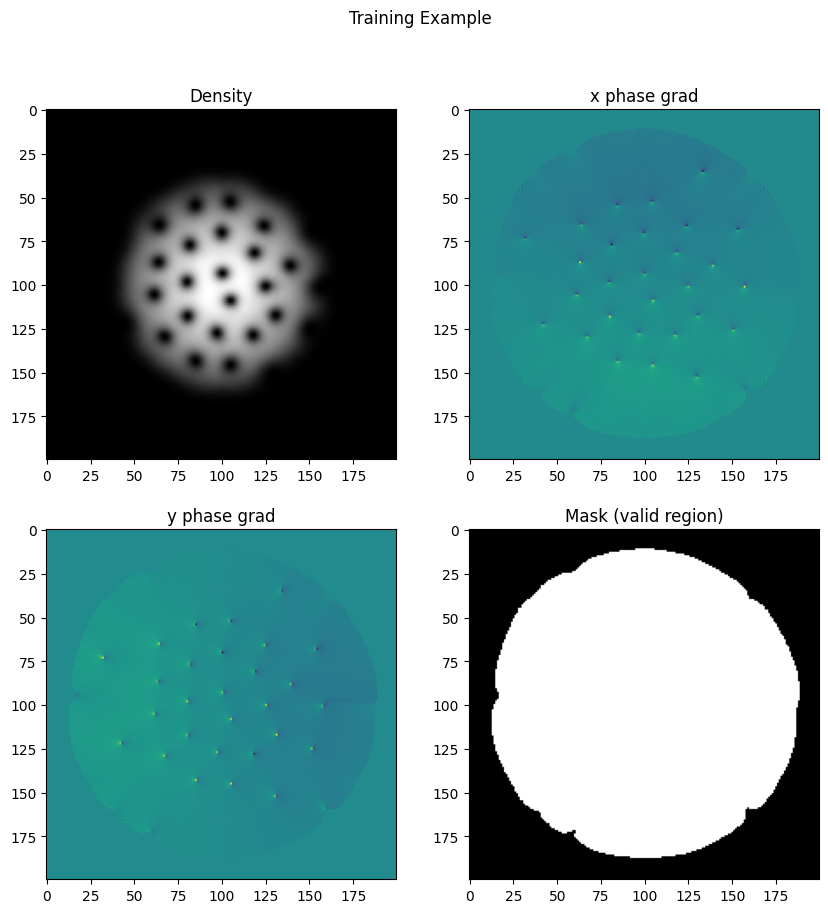

In [11]:
# Visualize an example
idx = 1
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes[0, 0].imshow(train_data['densities'][idx], cmap='gray')
axes[0, 1].imshow(train_data['phase_gradients'][idx, 0])
axes[1, 0].imshow(train_data['phase_gradients'][idx, 1])
axes[1, 1].imshow(1 - train_data['masks'][idx, 0], cmap = 'gray')

axes[0, 0].set_title("Density")
axes[0, 1].set_title("x phase grad")
axes[1, 0].set_title("y phase grad")
axes[1, 1].set_title("Mask (valid region)")

plt.suptitle("Training Example")

# Custom Datasets/Dataloaders

In [12]:
class BecDataset(Dataset):
    def __init__(self, densities, phase_grads, masks, log_eps=1e-9):
        """
        densities: (N, W, W)
        phase_grads: (N, 2, W, W)
        masks: (N, 2, W, W)
        log_eps: added before log() for numerical stability
        """
        self.densities = torch.tensor(densities).float().unsqueeze(1)
        self.phase_grads = torch.tensor(phase_grads).float()
        self.masks = torch.tensor(masks).float()
        self.log_eps = log_eps

    def __len__(self):
        return self.densities.size(0)

    def __getitem__(self, idx):
        density = self.densities[idx]
        density = torch.log(density + self.log_eps)
        phase_grad = self.phase_grads[idx]
        mask = self.masks[idx]
        return density, phase_grad, mask

train_dataset = BecDataset(train_data['densities'], train_data['phase_gradients'], train_data['masks'])
val_dataset = BecDataset(val_data['densities'], val_data['phase_gradients'], val_data['masks'])
test_dataset = BecDataset(test_data['densities'], test_data['phase_gradients'], test_data['masks'])

In [13]:
# Create corresponding dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, num_workers = 2)
test_loader = DataLoader(test_dataset, num_workers = 2)

# UNET Definition

In [14]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum = 0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum = 0.2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip = True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            #print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        #print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, channels, bilinear=True, add_skip = True, out_channels = 1, wrap_angles = False, verbose=False):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            #Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)] +
                                       [Down(channels[-1], channels[-1])])
            self.ups = nn.ModuleList([Up(2*channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)] +
                                     [Up(2* channels[1], channels[1], bilinear, add_skip)])
        else:
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)])
            self.ups = nn.ModuleList([Up(channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)])
        self.outc = OutConv(channels[1], out_channels)

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        for up in self.ups:
            x = up(x, x_stages.pop())
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        #Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2*torch.pi
            x = F.relu(x) - torch.pi
        return x

In [15]:
#Example usage, showing the channel sizes
unet_8 = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2, verbose = True)
dataiter = iter(train_loader)
images, labels, masks = next(dataiter)
print(images.shape)

output = unet_8(images);

torch.Size([8, 1, 200, 200])
x1 shape: torch.Size([8, 8, 200, 200])
Down stage shape: torch.Size([8, 16, 100, 100])
Down stage shape: torch.Size([8, 32, 50, 50])
Down stage shape: torch.Size([8, 64, 25, 25])
Down stage shape: torch.Size([8, 128, 12, 12])
Down stage shape: torch.Size([8, 256, 6, 6])
Down stage shape: torch.Size([8, 512, 3, 3])
Down stage shape: torch.Size([8, 512, 1, 1])
Up stage shape: torch.Size([8, 256, 3, 3])
Up stage shape: torch.Size([8, 128, 6, 6])
Up stage shape: torch.Size([8, 64, 12, 12])
Up stage shape: torch.Size([8, 32, 25, 25])
Up stage shape: torch.Size([8, 16, 50, 50])
Up stage shape: torch.Size([8, 8, 100, 100])
Up stage shape: torch.Size([8, 8, 200, 200])
Output shape: torch.Size([8, 2, 200, 200])


# Training


In [16]:
def predict(dataloader, model, device="cpu"):
    """
    Return *torch tensors* for inputs, predictions, ground_truths, masks, and errors.
    """
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask_batch = mask_batch.to(device)
            preds = model(inputs)

            inputs_list.append(inputs)
            predictions.append(preds)
            ground_truths.append(targets)
            masks.append(mask_batch)

    # Concatenate tensors over batch dimension
    return (
        torch.cat(inputs_list, dim=0),
        torch.cat(predictions, dim=0),
        torch.cat(ground_truths, dim=0),
        torch.cat(masks, dim=0),
    )

def train_model(train_loader, model, loss_fn, optimizer, epochs=10, device="cpu"):

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets, masks in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Run validation using torch-level predict()
        _, predictions, ground_truths, masks = predict(
            val_loader, model, device=device
        )
        val_loss = loss_fn(predictions, ground_truths, masks).item()

        print(f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}")

In [17]:
#Custom Loss function
#Ignores losses for masked out regions (mask = 1), as these are
#Low density regions and we don't care whether we get them right or not

def mse_with_mask(outputs, targets, masks, keep_first_dim = False):
    if keep_first_dim:
        return torch.mean(((outputs-targets)**2)*(1-masks), dim = (-1, -2, -3))
    else:
        return torch.mean(((outputs-targets)**2)*(1-masks))

unet_8 = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2)
optimizer = optim.Adam(unet_8.parameters(), lr=1e-3)

train_model(train_loader, unet_8, mse_with_mask, optimizer, epochs=20, device=device)

Epoch 1 Train Loss: 0.011742689532213031, Val Loss: 0.005007125437259674
Epoch 2 Train Loss: 0.004107566395153602, Val Loss: 0.004119172692298889
Epoch 3 Train Loss: 0.0033084883979181685, Val Loss: 0.0029622165020555258
Epoch 4 Train Loss: 0.002876684717309203, Val Loss: 0.0026018705684691668
Epoch 5 Train Loss: 0.0025110909759643533, Val Loss: 0.002392986323684454
Epoch 6 Train Loss: 0.002219123986645764, Val Loss: 0.002361246384680271
Epoch 7 Train Loss: 0.0021755711798230925, Val Loss: 0.0022407309152185917
Epoch 8 Train Loss: 0.0019363229955723952, Val Loss: 0.0019157321657985449
Epoch 9 Train Loss: 0.001845533152051743, Val Loss: 0.0018967640353366733
Epoch 10 Train Loss: 0.001800167530457238, Val Loss: 0.0017283560009673238
Epoch 11 Train Loss: 0.0016738006139233234, Val Loss: 0.0017228837823495269
Epoch 12 Train Loss: 0.0016368644871926378, Val Loss: 0.0015886854380369186
Epoch 13 Train Loss: 0.0016106637203992004, Val Loss: 0.0016976810293272138
Epoch 14 Train Loss: 0.00151938

# Test Set Evaluation

In [18]:
# Get test predictions
inputs, predictions, truths, masks = predict(test_loader, unet_8, device = device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim = True)

print(f"Error on the testing set: {errors.mean()}")

Error on the testing set: 0.0011495299404487014


In [19]:
# Convert to numpy arrays
inputs = inputs.cpu().numpy()
predictions = predictions.cpu().numpy()
truths = truths.cpu().numpy()
masks = masks.cpu().numpy()
errors = errors.cpu().numpy()

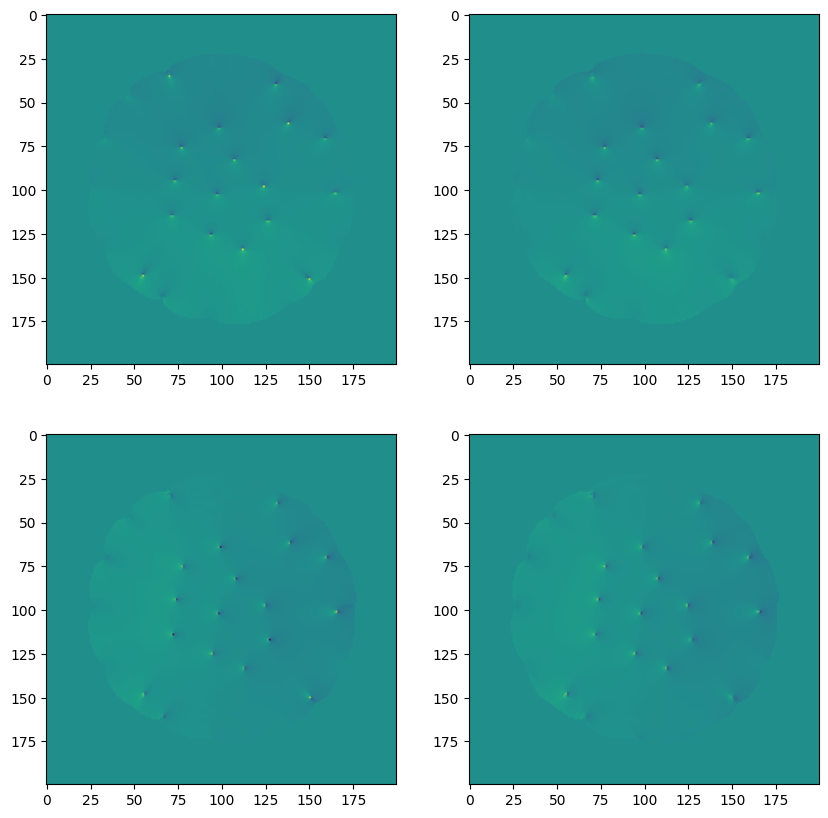

In [20]:
# Visualize a prediction
idx = 1
vmin = truths.min()
vmax = truths.max()
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes[0, 0].imshow(truths[idx, 0], vmin = vmin, vmax = vmax)
axes[0, 1].imshow(predictions[idx, 0] * (1 - masks[idx, 0]), vmin = vmin, vmax = vmax)
axes[1, 0].imshow(truths[idx, 1], vmin = vmin, vmax = vmax)
axes[1, 1].imshow(predictions[idx, 1] * (1 - masks[idx, 0]), vmin = vmin, vmax = vmax)

Text(0, 0.5, 'Frequency')

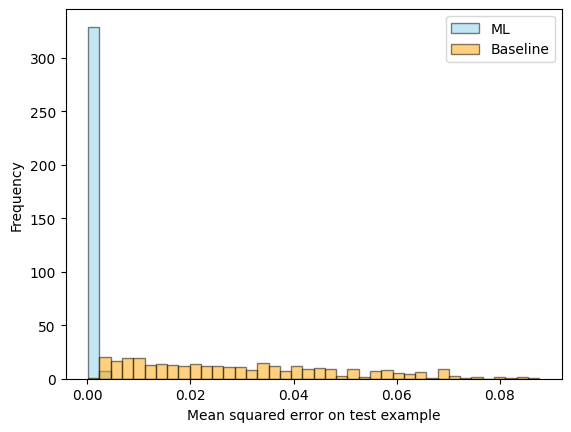

In [21]:
# Histogram of model test set errors and baseline errors.
baseline_errors = np.var(truths, axis = (-1, -2, -3))
all_errors = np.concatenate([errors, baseline_errors])

bin_edges = np.histogram_bin_edges(all_errors, bins=40)
plt.hist(errors, alpha = 0.5, bins = bin_edges, label = "ML", color='skyblue', edgecolor='black')
plt.hist(baseline_errors, alpha = 0.5, bins = bin_edges, label = "Baseline", color='orange', edgecolor='black')
plt.legend()
plt.xlabel("Mean squared error on test example")
plt.ylabel("Frequency")